# Simplex method

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def simplex_kernel(A, b, c, b_set, n_set, n = None, return_only_x = True):
    if n is None: _, n = A.shape
    
    while True:
        # Compute B and N
        B = A[:, b_set]
        N = A[:, n_set]
        
        # Compute x_B
        x_B = np.linalg.solve(B, b)
        
        # Compute c_B, c_N
        c_B = c[b_set]
        c_N = c[n_set]
        
        # Compute the reduced costs
        lag_mult = np.linalg.solve(B.T, c_B)
        s_N = c_N - N.T @ lag_mult
        
        # Check for optimality
        if all(s_N >= 0):
            break
        
        # Select q
        q_index = np.argmin(s_N)
        q = n_set[q_index]
        
        # Compute direction d
        d = np.linalg.solve(B, A[:, q])
        
        # Check for unboundedness
        if all(d <= 0):
            print("Unbounded problem!")
            return None, None
        
        # Select p
        ratios = np.divide(x_B, d, out=np.full_like(x_B, np.inf), where=d > 0)
        p_index = np.argmin(ratios)
        p = b_set[p_index]
        
        # Update the sets
        b_set[p_index] = q
        n_set[q_index] = p
    
    # Compute final solution
    final_x = np.zeros_like(c)
    final_x[b_set] = x_B
    
    if return_only_x: return final_x[:n], final_x.T @ c
    else: return final_x, b_set

def simplex_zero(A, b, c):
    m, n = A.shape
    
    # Add slacks
    slacks = np.eye(m)
    A = np.hstack((A, slacks))
    c = np.hstack((c, np.zeros(m)))
    
    # Initial basic and non-basic sets
    b_set = list(range(n, n + m))
    n_set = list(range(n))

    # Solve
    return simplex_kernel(A, b, c, b_set, n_set, n = n)
    


In [20]:
def find_feasible_point_simplex(A, b, c):
    m, n = A.shape
    
    # Phase 1. Construct the auxiliary problem
    A_ph1 = np.hstack([A, np.eye(m)])
    e = np.hstack([np.zeros(n), np.ones(m)])
    
    # Initial basic and non-basic sets for phase 1
    b_set = list(range(n, n + m))
    n_set = list(range(n))
    
    # Phase 1 simplex kernel
    _, b_set = simplex_kernel(A_ph1, b, e, b_set, n_set, return_only_x=False)
    
    # Phase 2. Back to the original problem
    n_set = [i for i in range(n+m) if i not in b_set]
    
    # Phase 2 simplex kernel
    A = np.hstack((A, np.eye(m)))
    c = np.hstack((c, np.zeros(m)))
    return simplex_kernel(A, b, c, b_set, n_set, n=n)

In [21]:
A= np.array([[-2,  6,  1, -4, -1,  2,  6, -5,  4,  6],
 [-4,  8,  2  ,4 ,-1 ,-4  ,2  ,1 ,-1  ,3],
 [ 4, -3,  7  ,1  ,0  ,3  ,7 ,-2  ,3  ,3],
 [ 1, -2,  7  ,2 ,-1  ,2  ,6 ,-3 ,-4 ,-3],
 [ 8, 14,  7 ,13  ,7 ,16 ,13 , 9  ,7 ,16],
 [ 3,  1,  3  ,2 ,10  ,0  ,7  ,2  ,9  ,1],
 [ 5,  1, -2  ,6  ,7  ,4  ,3 ,-1  ,0 ,-4],
 [ 6,  7,  4 ,12  ,3  ,2  ,4  ,4 ,10 ,13],
 [ 1, -5,  4  ,4  ,2 ,-1 ,-2  ,8  ,2 ,-2]]) 
b = np.array([12,  9, 22,  4,  1 , 1 ,18 , 1 ,10])
c = np.array([-2,  1,  1,  2,  0, -3, -3,  2,  0, -2])

find_feasible_point_simplex(A, b, c)

(array([0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 -0.25)

## 2D problems

In [22]:
def plot_feasible_set(constraint, x_low = -1, x_high = 9, y_low = -1, y_high = 9, step=0.01):
    domain = np.mgrid[x_low:x_high:step, y_low:y_high:step]
    x_ticks = [tick for i, tick in enumerate(domain[0,:,0]) if not i%50]
    y_ticks = [tick for i, tick in enumerate(domain[1,0]) if not i%50]
    domain = np.moveaxis(domain, 0,2)
    pos_x_c = lambda x: constraint(x) * int(all(x >= 0))
    feasible_set = np.apply_along_axis(pos_x_c, 2, domain)
    plt.imshow(feasible_set.T)
    plt.xticks(ticks=[i for i in np.arange(feasible_set.shape[1]) if not i%50],labels = x_ticks, fontsize=6)
    plt.yticks(ticks=[i for i in np.arange(feasible_set.shape[0]) if not i%50], labels = y_ticks, fontsize=6)
    plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)



### Problem 1

Let's consider $min \, c x $ such that $c = (-1,1)$;   $(3, 1) x + z_1 = 2$;   $(5, 2) x + z_2 = 5$ and $z_1, z_2 \geq 0$

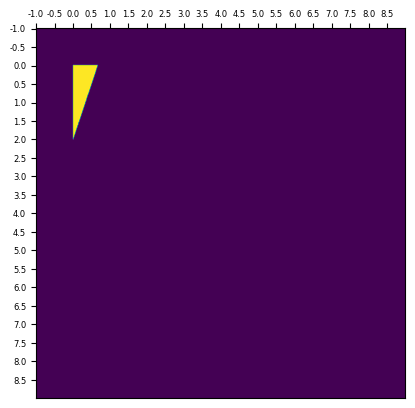

In [23]:
c1 = lambda x: int(3*x[0] + x[1] <= 2)
c2 = lambda x: int(5*x[0] + 2*x[1] <= 5)
c = lambda x: c1(x) * c2(x)
plot_feasible_set(c)

As we have a linear problem, we have also linear contour lines which means that the minimum is always in the one of the vertices. Therefore, we can find the vertices, evaluate them and pick the one with lowest value.

Vertices: $v_1 = (0,0), \, v_2 = (\frac23,0), \, v_3 = (0,2)$

Function values: $f(v_1) = 0, \, f(v_2) = -\frac23, \, f(v_3) = 2$

Therefore, we can clearly see that the the solution is $(\frac23,0)$


In [24]:
A = np.array([[3, 1], [5, 2]])
b = np.array([2, 5])
c = np.array([-1, 1])

x, min_value = simplex_zero(A, b, c)
print("Optimal solution:", x)
print("Optimal value:", min_value)

Optimal solution: [0.66666667 0.        ]
Optimal value: -0.6666666666666666


In [26]:
x, min_value = find_feasible_point_simplex(A, b, c)
print("Optimal solution:", x)
print("Optimal value:", min_value)

Optimal solution: [0.66666667 0.        ]
Optimal value: -0.6666666666666666


### Problem 2

Let's consider $min \, c x $ such that $c = (1,-0.5)$;   $(0, 2) x + z_1 = 3$;   and $z_1 \geq 0$

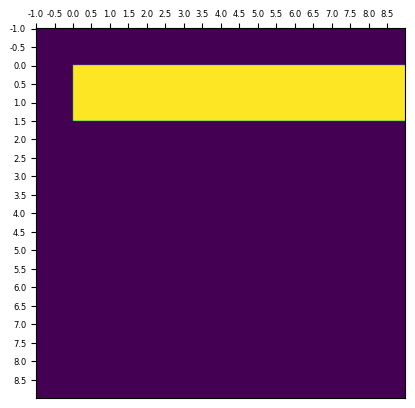

In [92]:
c1 = lambda x: int(2*x[1] <= 3)
c = lambda x: c1(x)
plot_feasible_set(c)

Note that vertex $(0, 1.5)$ has both maximal feasible $y$ and minimal feasible $x$. As we need to minimize $x$ and maximize $y$ we can immediatly see that it is an optimum.

In [27]:
A = np.array([[0, 2]])
b = np.array([3])
c = np.array([1, -0.5])

x, min_value = simplex_zero(A, b, c)
print("Optimal solution:", x)
print("Optimal value:", min_value)

Optimal solution: [0.  1.5]
Optimal value: -0.75


In [28]:
x, min_value = find_feasible_point_simplex(A, b, c)
print("Optimal solution:", x)
print("Optimal value:", min_value)

Optimal solution: [0.  1.5]
Optimal value: -0.75


### Problem 3

Let's consider $min \, c x $ such that $c = (-6,-2)$;   $(7, -1) x + z_1 = 5$;   $(-2, 3) x + z_2 = 0$ and $z_1, z_2 \geq 0$

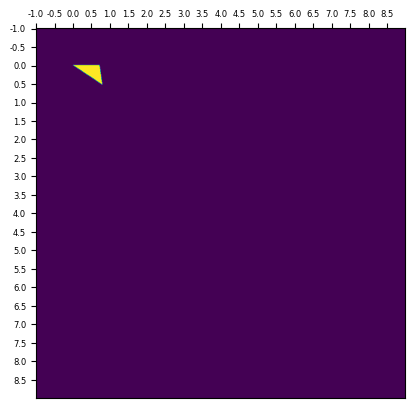

In [87]:
c1 = lambda x: int(7*x[0] - x[1] <= 5)
c2 = lambda x: int(-2*x[0] + 3*x[1] <= 0)
c = lambda x: c1(x) * c2(x)
plot_feasible_set(c)

By using the geometrical interpretation of simplex method, we start in $(0,0)$ and then make a step to the downermost vertex $(\frac{15}{19}, \frac{10}{19})$ (obtained by solving the linear system where both constraints are active), at that point there ar no longer directions pointing "away" from the function and $(\frac{15}{19}, \frac{10}{19})$ is therefore a local minimum. 


In [29]:
A = np.array([[7, -1], [-2, 3]])
b = np.array([5, 0])
c = np.array([-6, -2])

x, min_value = simplex_zero(A, b, c)
print("Optimal solution:", x)
print("Optimal value:", min_value)

Optimal solution: [0.78947368 0.52631579]
Optimal value: -5.789473684210526


In [30]:
x, min_value = find_feasible_point_simplex(A, b, c)
print("Optimal solution:", x)
print("Optimal value:", min_value)

Optimal solution: [0.78947368 0.52631579]
Optimal value: -5.789473684210526


### Problem 4

Let's consider $min \, c x $ such that $c = (-8,3)$;   $(-2, 3) x + z_1 = 0$;   $(-7, 9) x + z_2 = 0$;   $(1,0) x + z_3 = 6$ and $z_1, z_2, z_3 \geq 0$

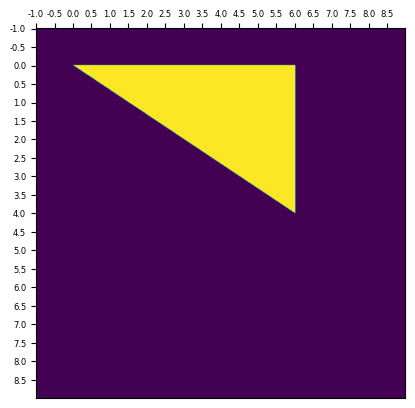

In [88]:
c1 = lambda x: int(-2*x[0] + 3*x[1] <= 0)
c2 = lambda x: int(-7*x[0] + 9*x[1] <= 0)
c3 = lambda x: int(x[0] <= 6)
c = lambda x: c1(x) * c2(x) * c3(x)
plot_feasible_set(c)

In this case, the solution again does not need much calculation. Note that vertex $(6, 0)$ has both maximal feasible $x$ and minimal feasible $y$. As we need to minimize $y$ and maximize $x$ we can immediatly see that it is an optimum.

In [17]:
A = np.array([[-2, 3], [-7, 9], [1, 0]])
b = np.array([0, 0, 6])
c = np.array([-8, 3])

x, min_value = simplex_zero(A, b, c)
print("Optimal solution:", x)
print("Optimal value:", min_value)

Optimal solution: [6. 0.]
Optimal value: -48.0


In [31]:
x, min_value = find_feasible_point_simplex(A, b, c)
print("Optimal solution:", x)
print("Optimal value:", min_value)

Optimal solution: [0.78947368 0.52631579]
Optimal value: -5.789473684210526


### Problem 5

Let's consider $min \, c x $ such that $c = (2,-3)$;   $(4,1) x + z_1 = 4$;   $(-1,4) x + z_2 = 2$;  $(1,1) x + z_3 = 1$; $(-4,7) x + z_4 = 2$ and $z_1, z_2, z_3, z_4 \geq 0 $

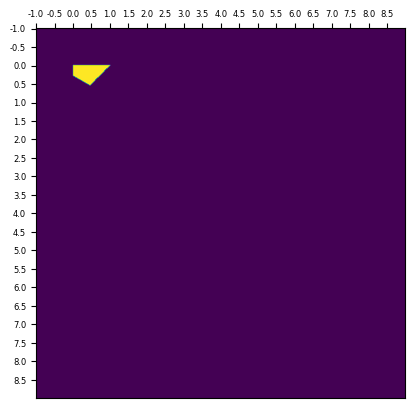

In [89]:
c1 = lambda x: int(4*x[0] + x[1] <= 4)
c2 = lambda x: int(-1*x[0] + 4*x[1] <= 2)
c3 = lambda x: int(x[0] + x[1] <= 1)
c4 = lambda x: int(-4*x[0] + 7*x[1] <= 2)
c = lambda x: c1(x) * c2(x) * c3(x) * c4(x)
plot_feasible_set(c)

By using the geometrical interpretation of simplex method, we start in $(0,0)$ and then make a step to the vertex $(0, \frac27)$ (found by noting that we move along $x_2 = 0$ and then find the tightest constraint) where the value is $- \frac67 \approx -0.857$. Without precise tools, it is hard to estimate, whether the the direction to the next vertex aligns well with the general descent direction. Therefore we will do the step, then compute the function value and based on that decide on the local minimum. 

The next vertex is $(\frac{5}{11}, \frac{6}{11})$ (solved by finding the constraint intersection that that involves $(-4,7) x + z_4 = 2$ and is best aligned with the sketch) where the function value is $- \frac{8}{11} \approx -0.727$ which is larger than the previous one-

Therefore, $(0, \frac27)$ is a local solution.


In [33]:
A = np.array([[4, 1], [-1, 4], [1, 1], [-4, 7]])
b = np.array([4, 2, 1, 2])
c = np.array([2, -3])

x, min_value = simplex_zero(A, b, c)
print("Optimal solution:", x)
print("Optimal value:", min_value)

Optimal solution: [0.         0.28571429]
Optimal value: -0.8571428571428571


In [34]:
x, min_value = find_feasible_point_simplex(A, b, c)
print("Optimal solution:", x)
print("Optimal value:", min_value)

Optimal solution: [0.         0.28571429]
Optimal value: -0.8571428571428571


## 10D problems

In [36]:
def make_problem(dim = 10):
    # Create the linear function
    c = np.random.randint(-5,5,size = dim)
    # Create the contstraint LHS
    n_constraints = np.random.randint(3, 12)
    A = np.random.randint(-5, 9, size = (n_constraints, dim))
    # Ensure that constraint RHS is smaller then LHS
    b = np.sum(A, axis = 1) - 1
    # Make sure that constrain
    for i, b_i in enumerate(b):
        if b_i < 0:
            b[i] = 1
            A[i, :] -= b_i - 1

    return A, b, c


### Problem 1

In [37]:
A,b,c = make_problem()
print("A:",A)
print("b:",b)
print("c:",c)
x, min_value = simplex_zero(A, b, c)
print("Optimal solution when starting at 0:", x)
print("Optimal value when starting at 0:", min_value)
x, min_value = find_feasible_point_simplex(A, b, c)
print("Optimal solution with 2-phase method:", x)
print("Optimal value with 2-phase method:", min_value)

A: [[ 5  5  5  8 -4 -3 -5 -3 -4 -3]
 [ 2 -1  1 -1 -1  4  2  8  0  1]
 [ 2  8  5 -1  6  1  1 -4  2  6]
 [ 4  8  0 -4 -3  2  0  8 -4 -3]
 [-2  3 -1  5  3  4  6  6  1  6]
 [ 1 -2 -3  2  3  3  7  7  3  4]
 [-5  6  7  1  1  5 -3  7  8 -1]
 [ 4 -2  8 -5  4  3  3  8  4 -5]
 [-3  1 -5  3  2  8  1 -2 -4  6]]
b: [ 0 14 25  7 30 24 25 21  6]
c: [-4  2 -3  2  2 -2 -1 -1 -2  1]
Optimal solution when starting at 0: [3.90737834 0.         0.         0.         0.         1.10361068
 0.         0.         2.72841444 1.77080063]
Optimal value when starting at 0: -21.522762951334386
Optimal solution with 2-phase method: [3.90737834 0.         0.         0.         0.         1.10361068
 0.         0.         2.72841444 1.77080063]
Optimal value with 2-phase method: -21.522762951334382


### Problem 2

In [38]:
A,b,c = make_problem()
print("A:",A)
print("b:",b)
print("c:",c)
x, min_value = simplex_zero(A, b, c)
print("Optimal solution when starting at 0:", x)
print("Optimal value when starting at 0:", min_value)
x, min_value = find_feasible_point_simplex(A, b, c)
print("Optimal solution with 2-phase method:", x)
print("Optimal value with 2-phase method:", min_value)

A: [[ 8  1  7 -4  1  1 -1  6 -3 -3]
 [-2  5 -2  5  0  8  2 -1  4 -5]
 [ 3 -5  0 -4  3  6 -3  5 -1 -1]
 [ 3 -2  8  3 -2  8 -1  6  7 -1]
 [ 6 -1 -2  0  6  4  4  2  5 -4]
 [-2  2  4  0  0  8 -4  3  2 -1]
 [ 6  5  8  2  0  7  0  7 -3  0]
 [ 2 -3 -4 -5  4 -5  3  6  5 -2]
 [-1  3  6  2  0  1 -4 -2  5  3]]
b: [12 13  2 28 19 11 31  0 12]
c: [ 3 -2 -2  4 -3 -1 -4  2 -1  1]
Optimal solution when starting at 0: [  0.    0.    0.   15.5   0.    0.  194.5   0.    0.  253. ]
Optimal value when starting at 0: -463.00000000000165
Optimal solution with 2-phase method: [  0.    0.    0.   15.5   0.    0.  194.5   0.    0.  253. ]
Optimal value with 2-phase method: -462.99999999999915


### Problem 3

In [39]:
A,b,c = make_problem()
print("A:",A)
print("b:",b)
print("c:",c)
x, min_value = simplex_zero(A, b, c)
print("Optimal solution when starting at 0:", x)
print("Optimal value when starting at 0:", min_value)
x, min_value = find_feasible_point_simplex(A, b, c)
print("Optimal solution with 2-phase method:", x)
print("Optimal value with 2-phase method:", min_value)

A: [[-1  8  7  4  6  8  7  1 -2  0]
 [ 2  8 -2  0  0 -1 -5  0  8 -3]
 [-3  7  1 -1 -5 -4  4  3 -2  6]
 [ 8  0 -4 -3  8  1 -2  8  0  5]
 [-3  5  8  0 -4  2  6  7 -3  5]
 [-1 -2 -2  3 -1  5 -1  5  5  8]
 [ 8  2  5  7 -4 -2 -1 -2  7  8]
 [ 4  2  1 -5  4  4 -4  0  0  5]
 [ 6 -1 -1  1 -3 -3  2  6  4  0]
 [-4  5  8  1  5 -5  0  5  6  3]
 [-4  8  3  2  0  8 -5 -4  7  2]]
b: [37  6  5 20 22 18 27 10 10 23 16]
c: [ 1  3 -4  1  0 -1  0  2  4 -3]
Optimal solution when starting at 0: [0.         0.         2.90788602 0.         0.81974818 0.89860835
 0.         0.         0.         0.04373757]
Optimal value when starting at 0: -12.661365142478463
Optimal solution with 2-phase method: [0.         0.         2.90788602 0.         0.81974818 0.89860835
 0.         0.         0.         0.04373757]
Optimal value with 2-phase method: -12.661365142478463


### Problem 4 

In [41]:
A,b,c = make_problem()
print("A:",A)
print("b:",b)
print("c:",c)
x, min_value = simplex_zero(A, b, c)
print("Optimal solution when starting at 0:", x)
print("Optimal value when starting at 0:", min_value)
x, min_value = find_feasible_point_simplex(A, b, c)
print("Optimal solution with 2-phase method:", x)
print("Optimal value with 2-phase method:", min_value)

A: [[ 1  5  6  3  2  7  8  1  8 -3]
 [-3  5  0  0  3  5  2  7  5 -1]
 [ 5  7 -5  2  5 -2  5  4  8 -2]
 [ 5  4  1 -1 -4  3  2 -2  5  5]
 [ 7  1  1  2  7  2 -1  3  8  3]
 [12 12 16 13 23 11 18 11 17 13]
 [-1 -2 -4  2  7  1  2  8 -4 -3]
 [-2 -1  7 -5  7  3 -1 -3  4  3]
 [ 0  3  0 -3 -3 -5  4  6  4  7]
 [15  5  7 13  3  8 11  3  4  5]]
b: [37 22 26 17 32  1  5 11 12  1]
c: [ 3  1  4 -3  1 -3 -5 -3  3  0]
Optimal solution when starting at 0: [0.         0.         0.         0.         0.         0.
 0.05555556 0.         0.         0.        ]
Optimal value when starting at 0: -0.2777777777777778
Optimal solution with 2-phase method: [0.         0.         0.         0.         0.         0.
 0.05555556 0.         0.         0.        ]
Optimal value with 2-phase method: -0.2777777777777778


### Problem 5

In [45]:
A,b,c = make_problem()
print("A:",A)
print("b:",b)
print("c:",c)
x, min_value = simplex_zero(A, b, c)
print("Optimal solution when starting at 0:", x)
print("Optimal value when starting at 0:", min_value)
x, min_value = find_feasible_point_simplex(A, b, c)
print("Optimal solution with 2-phase method:", x)
print("Optimal value with 2-phase method:", min_value)

A: [[ 5  0  5  1 -3  3  7 -5 -5  2]
 [ 7  3  0 -5  8  6 -1  0  3  6]
 [ 8  2  3 -2  2 -3  3  6  6  8]
 [ 7 -4  1  3  0  3  8  4  5  7]
 [-2 11 -2  7  0  9 -1  0  0  7]
 [-5  1  5 -1 -5  4  2  5  3  7]]
b: [ 9 26 32 33  1 15]
c: [ 3  2  2 -2  2 -4 -4  1  1 -2]
Optimal solution when starting at 0: [0.         0.         0.         0.         0.         0.40919674
 2.68277066 0.6967404  1.50465658 0.        ]
Optimal value when starting at 0: -10.166472642607681
Optimal solution with 2-phase method: [0.         0.         0.         0.         0.         0.40919674
 2.68277066 0.6967404  1.50465658 0.        ]
Optimal value with 2-phase method: -10.166472642607681
